# 基于 PyTorch  在 SecretFlow 中实现水平联邦音频分类任务

## 引言
本教程基于 PyTorch 的 [微软教程：使用 PyTorch 进行音频分类简介教程](https://learn.microsoft.com/zh-cn/training/modules/intro-audio-classification-pytorch/) 而改写，通过本教程，您将了解到现有的基于 PyTorch 的示例如何快速地迁移到 SecretFlow 隐语的联邦学习框架之下，实现模型的联邦学习化。

## 单机模式

### 小节引言

本小节的代码主要来自于 [使用 PyTorch 进行音频分类简介教程](https://learn.microsoft.com/zh-cn/training/modules/intro-audio-classification-pytorch/) ，主要讲解如何在 PyTorch 下利用简单的神经网络进行音频分类。 为了教程的简洁，本小节仅仅简要介绍了一下各部分的功能；对于实现的具体解析，请读者移步参考[原教程](https://learn.microsoft.com/zh-cn/training/modules/intro-audio-classification-pytorch/)。

### 安装 TorchAudio

In [1]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/audio-pytorch/install-packages.txt

In [2]:
# import the packages
import os
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt

### 下载 speech commands 数据集

In [3]:
default_dir = os.getcwd()
folder = 'data'
print(f'Data directory will be: {default_dir}/{folder}')

if os.path.isdir(folder):
    print("Data folder exists.")
else:
    print("Creating folder.")
    os.mkdir(folder)

Data directory will be: /home/limingbo/workshop/secretflow/docs/tutorial/data
Data folder exists.


In [4]:
trainset_speechcommands = torchaudio.datasets.SPEECHCOMMANDS(
    f'./{folder}/', download=True
)

In [5]:
os.chdir(f'./{folder}/SpeechCommands/speech_commands_v0.02/')
labels = [name for name in os.listdir('.') if os.path.isdir(name)]
# back to default directory
os.chdir(default_dir)
print(f'Total Labels: {len(labels)} \n')
print(f'Label Names: {labels}')

Total Labels: 36 

Label Names: ['follow', 'wow', 'learn', 'left', 'yes', 'stop', 'three', 'one', 'tree', 'seven', 'bed', 'on', 'off', 'up', 'right', 'down', 'dog', 'six', 'two', 'cat', 'sheila', 'eight', 'happy', 'four', 'visual', '_background_noise_', 'marvin', 'nine', 'bird', 'five', 'no', 'zero', 'backward', 'house', 'forward', 'go']


### 把声音转换为张量

In [6]:
filename = "./data/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav"
waveform, sample_rate = torchaudio.load(uri=filename, num_frames=3)
print(f'waveform tensor with 3 frames:  {waveform} \n')
waveform, sample_rate = torchaudio.load(uri=filename, num_frames=3, frame_offset=2)
print(f'waveform tensor with 2 frame_offsets: {waveform} \n')
waveform, sample_rate = torchaudio.load(uri=filename)
print(f'waveform tensor:  {waveform}')

waveform tensor with 3 frames:  tensor([[0.0005, 0.0007, 0.0005]]) 

waveform tensor with 2 frame_offsets: tensor([[0.0005, 0.0004, 0.0007]]) 

waveform tensor:  tensor([[0.0005, 0.0007, 0.0005,  ..., 0.0008, 0.0008, 0.0007]])


### 可视化波形

In [7]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    plt.figure()
    plt.plot(waveform.t().numpy())

    return waveform, sample_rate

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


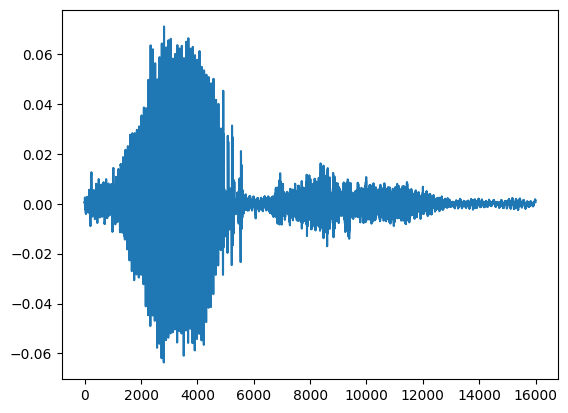

In [8]:
filename = "./data/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


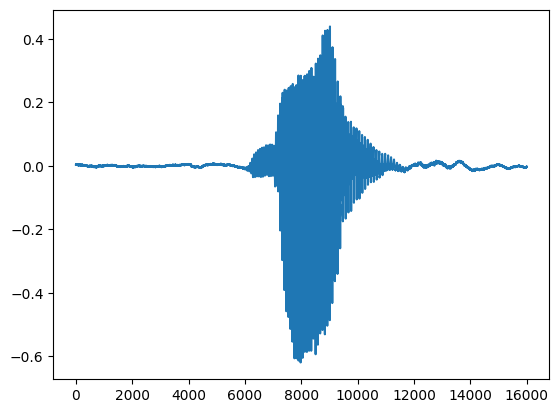

In [9]:
filename = "./data/SpeechCommands/speech_commands_v0.02/no/0b40aa8e_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

### 加载数据集文件夹进入 DataLoader

In [10]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [11]:
def load_audio_files(path: str, label: str):
    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)

        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])

    return dataset

In [12]:
trainset_speechcommands_yes = load_audio_files(
    './data/SpeechCommands/speech_commands_v0.02/yes', 'yes'
)
trainset_speechcommands_no = load_audio_files(
    './data/SpeechCommands/speech_commands_v0.02/no', 'no'
)

In [13]:
print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')

Length of yes dataset: 4044
Length of no dataset: 3941


In [14]:
trainloader_yes = torch.utils.data.DataLoader(
    trainset_speechcommands_yes, batch_size=1, shuffle=True, num_workers=0
)

In [15]:
trainloader_no = torch.utils.data.DataLoader(
    trainset_speechcommands_no, batch_size=1, shuffle=True, num_workers=0
)

In [16]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]} \n')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714 

No Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
No Sample Rate: 16000
No Label: no
No ID: 012c8314


### 变换和可视化

In [17]:
def show_waveform(waveform, sample_rate, label):
    print(
        "Waveform: {}\nSample rate: {}\nLabels: {} \n".format(
            waveform, sample_rate, label
        )
    )
    new_sample_rate = sample_rate / 10

    # Resample applies to a single channel, we resample first channel here
    channel = 0
    waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(
        waveform[channel, :].view(1, -1)
    )

    print(
        "Shape of transformed waveform: {}\nSample rate: {}".format(
            waveform_transformed.size(), new_sample_rate
        )
    )

    plt.figure()
    plt.plot(waveform_transformed[0, :].numpy())

Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Sample rate: 16000
Labels: yes 

Shape of transformed waveform: torch.Size([1, 1600])
Sample rate: 1600.0


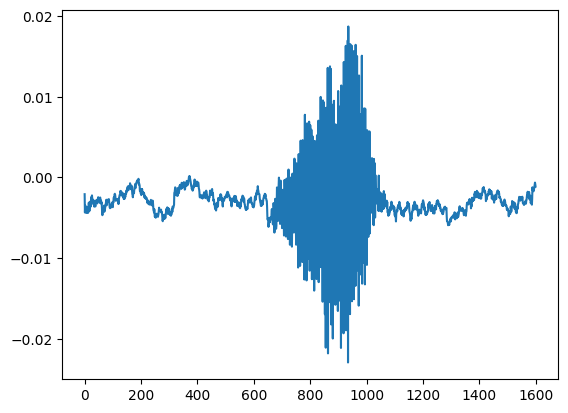

In [18]:
show_waveform(yes_waveform, yes_sample_rate, 'yes')

Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
Sample rate: 16000
Labels: no 

Shape of transformed waveform: torch.Size([1, 1600])
Sample rate: 1600.0


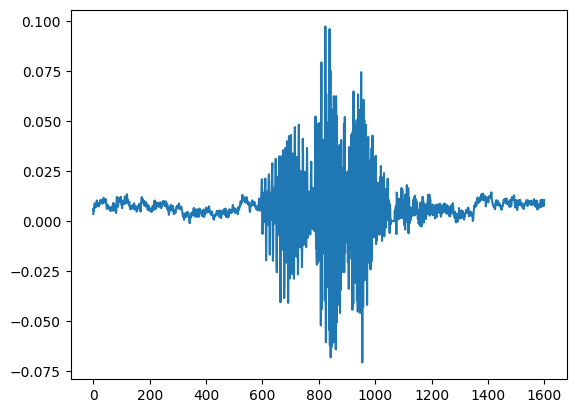

In [19]:
show_waveform(no_waveform, no_sample_rate, 'no')

### 频谱图

In [20]:
def show_spectrogram(waveform_classA, waveform_classB):
    yes_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classA)
    print("\nShape of yes spectrogram: {}".format(yes_spectrogram.size()))

    no_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classB)
    print("Shape of no spectrogram: {}".format(no_spectrogram.size()))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Features of {}".format('no'))
    plt.imshow(yes_spectrogram.log2()[0, :, :].numpy(), cmap='viridis')

    plt.subplot(1, 2, 2)
    plt.title("Features of {}".format('yes'))
    plt.imshow(no_spectrogram.log2()[0, :, :].numpy(), cmap='viridis')


Shape of yes spectrogram: torch.Size([1, 201, 81])
Shape of no spectrogram: torch.Size([1, 201, 81])


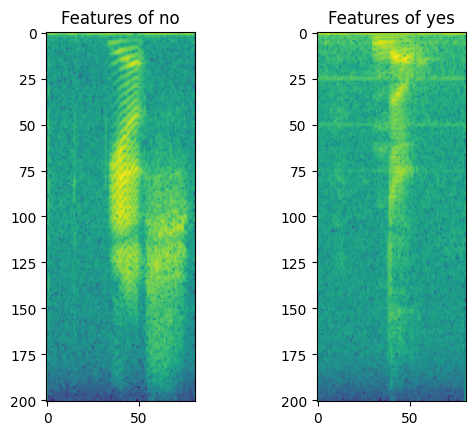

In [21]:
show_spectrogram(yes_waveform, no_waveform)

### 梅尔频谱图

In [22]:
def show_melspectrogram(waveform, sample_rate):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

    plt.figure()
    plt.imshow(mel_spectrogram.log2()[0, :, :].numpy(), cmap='viridis')

Shape of spectrogram: torch.Size([1, 128, 81])


/opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


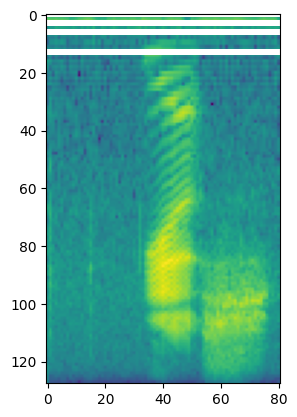

In [23]:
show_melspectrogram(yes_waveform, yes_sample_rate)

### 梅尔倒频谱系数（Mel-frequency cepstral coefficients , MFCC）

In [24]:
def show_mfcc(waveform, sample_rate):
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate=sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mfcc_spectrogram.size()))

    plt.figure()
    fig1 = plt.gcf()
    plt.imshow(mfcc_spectrogram.log2()[0, :, :].numpy(), cmap='viridis')

    plt.figure()
    plt.plot(mfcc_spectrogram.log2()[0, :, :].numpy())
    plt.draw()

Shape of spectrogram: torch.Size([1, 40, 81])


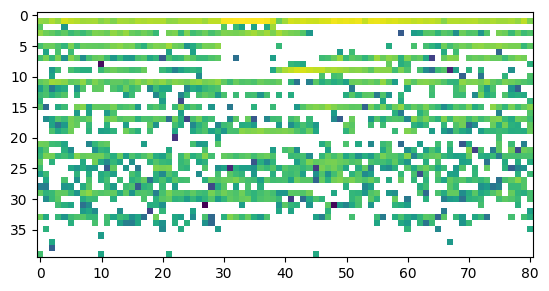

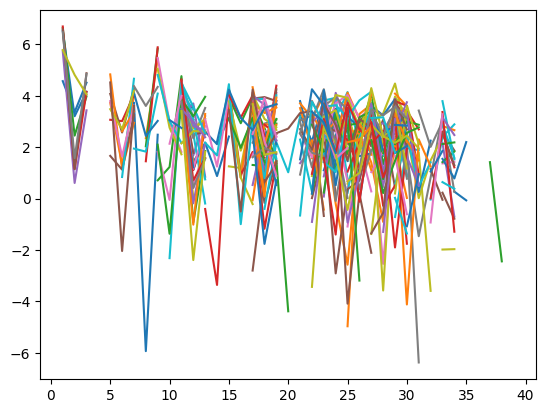

In [25]:
show_mfcc(no_waveform, no_sample_rate)

### 基于频谱图创建图像

In [26]:
def create_spectrogram_images(trainloader, label_dir):
    # make directory
    directory = f'./data/spectrograms/{label_dir}/'
    if os.path.isdir(directory):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)

        for i, data in enumerate(trainloader):
            waveform = data[0]
            sample_rate = data[1][0]
            label = data[2]
            ID = data[3]

            # create transformed waveforms
            spectrogram_tensor = torchaudio.transforms.Spectrogram()(waveform)

            fig = plt.figure()
            plt.imsave(
                f'./data/spectrograms/{label_dir}/spec_img{i}.png',
                spectrogram_tensor[0].log2()[0, :, :].numpy(),
                cmap='viridis',
            )

In [27]:
def create_mfcc_images(trainloader, label_dir):
    # make directory
    os.makedirs(f'./data/mfcc_spectrograms/{label_dir}/', mode=0o777, exist_ok=True)

    for i, data in enumerate(trainloader):
        waveform = data[0]
        sample_rate = data[1][0]
        label = data[2]
        ID = data[3]

        mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate=sample_rate)(waveform)

        plt.figure()
        fig1 = plt.gcf()
        plt.imshow(mfcc_spectrogram[0].log2()[0, :, :].numpy(), cmap='viridis')
        plt.draw()
        fig1.savefig(f'./data/mfcc_spectrograms/{label_dir}/spec_img{i}.png', dpi=100)

        # spectorgram_train.append([spectrogram_tensor, label, sample_rate, ID])

In [28]:
create_spectrogram_images(trainloader_yes, 'yes')
create_spectrogram_images(trainloader_no, 'no')

Data exists for yes
Data exists for no


In [29]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import pandas as pd
import os

### 加载频谱图到 DataLoader 进行训练

In [30]:
data_path = './data/spectrograms'  # looking in subfolder train

yes_no_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([transforms.Resize((201, 81)), transforms.ToTensor()]),
)
print(yes_no_dataset)

Dataset ImageFolder
    Number of datapoints: 7985
    Root location: ./data/spectrograms
    StandardTransform
Transform: Compose(
               Resize(size=(201, 81), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [31]:
class_map = yes_no_dataset.class_to_idx

print("\nClass category and index of the images: {}\n".format(class_map))


Class category and index of the images: {'no': 0, 'yes': 1}



### 划分训练数据和测试数据

In [32]:
# split data to test and train
# use 80% to train
train_size = int(0.8 * len(yes_no_dataset))
test_size = len(yes_no_dataset) - train_size
yes_no_train_dataset, yes_no_test_dataset = torch.utils.data.random_split(
    yes_no_dataset, [train_size, test_size]
)

print("Training size:", len(yes_no_train_dataset))
print("Testing size:", len(yes_no_test_dataset))

Training size: 6388
Testing size: 1597


In [33]:
from collections import Counter

# labels in training set
train_classes = [label for _, label in yes_no_train_dataset]
Counter(train_classes)

Counter({0: 3193, 1: 3195})

In [34]:
train_dataloader = torch.utils.data.DataLoader(
    yes_no_train_dataset, batch_size=15, num_workers=2, shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    yes_no_test_dataset, batch_size=15, num_workers=2, shuffle=True
)

In [35]:
td = train_dataloader.dataset[0][0][0][0]
print(td)

tensor([0.4745, 0.5451, 0.5333, 0.4275, 0.4745, 0.2235, 0.5255, 0.2510, 0.4471,
        0.1725, 0.1176, 0.5529, 0.3098, 0.5255, 0.4667, 0.1294, 0.3412, 0.3255,
        0.5451, 0.3490, 0.4863, 0.5137, 0.4667, 0.6235, 0.2196, 0.1725, 0.4039,
        0.5451, 0.3333, 0.2078, 0.4941, 0.3020, 0.3490, 0.3569, 0.4667, 0.4863,
        0.5451, 0.4118, 0.5059, 0.4863, 0.6039, 0.5922, 0.6039, 0.5137, 0.3922,
        0.5725, 0.5725, 0.4667, 0.1176, 0.5333, 0.5725, 0.4392, 0.3922, 0.5255,
        0.5059, 0.4196, 0.4549, 0.3098, 0.4196, 0.4549, 0.1333, 0.4196, 0.4392,
        0.4549, 0.4863, 0.6863, 0.6353, 0.3922, 0.6549, 0.4941, 0.6235, 0.4471,
        0.3255, 0.2235, 0.4863, 0.5451, 0.4667, 0.5137, 0.2667, 0.6235, 0.5725])


In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### 构建卷积神经网络

In [37]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)


model = CNNet().to(device)

### 构建训练和测试函数

In [38]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function


def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


# Create the validation/test function


def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1) == Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

### 训练模型

In [39]:
epochs = 15

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader, model, cost, optimizer)
    test(test_dataloader, model)
print('Done!')

Epoch 1
-------------------------------
loss: 0.693147  [    0/ 6388]
loss: 0.678901  [ 1500/ 6388]
loss: 0.443748  [ 3000/ 6388]
loss: 0.523017  [ 4500/ 6388]
loss: 0.512554  [ 6000/ 6388]

Test Error:
acc: 91.4%, avg loss: 0.014311

Epoch 2
-------------------------------
loss: 0.232422  [    0/ 6388]
loss: 0.589198  [ 1500/ 6388]
loss: 0.150064  [ 3000/ 6388]
loss: 0.189455  [ 4500/ 6388]
loss: 0.152220  [ 6000/ 6388]

Test Error:
acc: 92.7%, avg loss: 0.012255

Epoch 3
-------------------------------
loss: 0.045995  [    0/ 6388]
loss: 0.130162  [ 1500/ 6388]
loss: 0.151662  [ 3000/ 6388]
loss: 0.162012  [ 4500/ 6388]
loss: 0.914063  [ 6000/ 6388]

Test Error:
acc: 93.4%, avg loss: 0.010353

Epoch 4
-------------------------------
loss: 0.075109  [    0/ 6388]
loss: 0.336659  [ 1500/ 6388]
loss: 0.084331  [ 3000/ 6388]
loss: 0.118936  [ 4500/ 6388]
loss: 0.131541  [ 6000/ 6388]

Test Error:
acc: 94.4%, avg loss: 0.009808

Epoch 5
-------------------------------
loss: 0.085149  [   

### 测试模型

In [41]:
model.eval()
test_loss, correct = 0, 0
class_map = ['no', 'yes']

with torch.no_grad():
    for batch, (X, Y) in enumerate(test_dataloader):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        print(
            "Predicted:\nvalue={}, class_name= {}\n".format(
                pred[0].argmax(0), class_map[pred[0].argmax(0)]
            )
        )
        print("Actual:\nvalue={}, class_name= {}\n".format(Y[0], class_map[Y[0]]))
        break

Predicted:
value=0, class_name= no

Actual:
value=0, class_name= no



## 联邦学习
### 小节引言
通过单机模式，我们基于微软的[教程](https://learn.microsoft.com/zh-cn/training/modules/intro-audio-classification-pytorch/) 完成了基于 PyTorch 的音频分类任务。接下来，我们将看到如何将单机模式下的音频分类任务迁移到隐语的联邦学习模式之下。

In [42]:
%load_ext autoreload
%autoreload 2

### 数据划分
首先为了模拟联邦学习多方参与的场景设定，我们先人为进行一下数据集划分。为方便演示，我们对数据按参与方进行均匀划分

#### 查看数据集结构
我们可以看到数据集的路径是 **"./data/spectrograms"**

In [43]:
print(data_path)

./data/spectrograms


In [44]:
os.listdir(data_path)

['yes', 'no']

In [45]:
subdataset_yes_path = os.path.join(data_path, 'yes')
os.listdir(subdataset_yes_path)[:20]

['spec_img2947.png',
 'spec_img988.png',
 'spec_img2426.png',
 'spec_img3850.png',
 'spec_img473.png',
 'spec_img3641.png',
 'spec_img298.png',
 'spec_img1094.png',
 'spec_img344.png',
 'spec_img476.png',
 'spec_img1127.png',
 'spec_img3695.png',
 'spec_img2039.png',
 'spec_img724.png',
 'spec_img354.png',
 'spec_img3701.png',
 'spec_img1603.png',
 'spec_img1092.png',
 'spec_img3040.png',
 'spec_img3133.png']

#### 给定参与方
我们假定联邦学习的数据拥有方是 **alice** 和 **bob**

In [46]:
parties_list = ['alice', 'bob']

#### 建立数据文件夹

由上述结果，我们可以看到，语音分类的训练数据集经过预处理后，主要由频谱图组成，并且包含两个种类：是（yes）和否（no），分别位于 **"./data/spectrograms/yes"** 和 **"./data/spectrograms/no"** ；联邦学习模型的数据输入从此处开始；我们的参与方数据文件夹分别为 **"./fl-data/spectrograms/alice/"** 和 **"./fl-data/spectrograms/bob/"**；所以我们分别在参与方数据文件夹下建立 **'yes'** 和 **'no'** 来保存对应的数据。

In [47]:
dataset_name = "spectrograms"
parties_path_list = []
split_dataset_path = os.path.join('.', 'fl-data', dataset_name)

for party in parties_list:
    party_path = os.path.join('.', 'fl-data', dataset_name, party)
    os.makedirs(party_path, exist_ok=True)
    parties_path_list.append(party_path)

In [48]:
parties_path_list

['./fl-data/spectrograms/alice', './fl-data/spectrograms/bob']

In [49]:
commands = os.listdir(data_path)

In [50]:
if 'README.md' in commands:
    commands.remove('README.md')
elif '.DS_Store' in commands:
    commands.remove('.DS_Store')

In [51]:
commands

['yes', 'no']

#### 进行数据集划分

In [52]:
from os.path import join
import shutil

parties_num = len(parties_list)
for command in commands:
    command_path = join(data_path, command)
    for party_path in parties_path_list:
        party_command_path = join(party_path, command)
        print(party_command_path)
        os.makedirs(party_command_path, exist_ok=True)

    index = 0
    for wav_name in os.listdir(command_path):
        wav_path = join(command_path, wav_name)
        target_dir_path = join(
            '.', 'fl-data', dataset_name, parties_list[index % parties_num], command
        )
        shutil.copy(wav_path, target_dir_path)
        # if you want to watch the progress of copying the files, please uncomment the following line
        # print(f'copy {wav_path}-->{target_dir_path}')
        index += 1

./fl-data/spectrograms/alice/yes
./fl-data/spectrograms/bob/yes
./fl-data/spectrograms/alice/no
./fl-data/spectrograms/bob/no


查看参与方的各个文件夹下所拥有的文件数目

In [53]:
for command in commands:
    for party_path in parties_path_list:
        command_path = join(party_path, command)
        file_num = len(os.listdir(command_path))
        print(f'{command_path} : {file_num}')

./fl-data/spectrograms/alice/yes : 2022
./fl-data/spectrograms/bob/yes : 2022
./fl-data/spectrograms/alice/no : 1971
./fl-data/spectrograms/bob/no : 1970


### 隐语环境初始化

In [54]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'charlie'], address="local", log_to_driver=False)
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.2.0.dev20231009


2023-10-24 01:03:11,117	INFO worker.py:1538 -- Started a local Ray instance.


### 封装 DataBuilder

在迁移过程，对于数据集的预处理方式，联邦学习模式和单机模式是一样的，我们不再重复。为了完成迁移适配过程，我们只需要参考[在 SecretFlow 中使用自定义 DataBuilder（Torch）](https://github.com/secretflow/secretflow/blob/main/docs/tutorial/CustomDataLoaderTorch.ipynb) 封装我们自定义 DataBuilder 即可。现在，参考原教程，我们封装对应的DataBuilder。

In [55]:
def create_dataset_builder(
    batch_size=32,
    train_split=0.8,
    shuffle=True,
    random_seed=1234,
):
    def dataset_builder(data_path, stage="train"):
        """ """
        import math

        import numpy as np
        from torch.utils.data import DataLoader
        from torch.utils.data.sampler import SubsetRandomSampler
        from torchvision import datasets, transforms

        # Define dataset
        yes_no_dataset = datasets.ImageFolder(
            root=data_path,
            transform=transforms.Compose(
                [transforms.Resize((201, 81)), transforms.ToTensor()]
            ),
        )

        dataset_size = len(yes_no_dataset)
        # Define sampler

        indices = list(range(dataset_size))
        if shuffle:
            np.random.seed(random_seed)
            np.random.shuffle(indices)
        split = int(np.floor(train_split * dataset_size))
        train_indices, val_indices = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        # Define databuilder
        train_loader = DataLoader(
            yes_no_dataset, batch_size=batch_size, sampler=train_sampler
        )
        valid_loader = DataLoader(
            yes_no_dataset, batch_size=batch_size, sampler=valid_sampler
        )

        # Return
        if stage == "train":
            train_step_per_epoch = math.ceil(split / batch_size)

            return train_loader, train_step_per_epoch
        elif stage == "eval":
            eval_step_per_epoch = math.ceil((dataset_size - split) / batch_size)
            return valid_loader, eval_step_per_epoch

    return dataset_builder

### 构建 dataset_builder_dict

In [56]:
# prepare dataset dict
data_builder_dict = {
    alice: create_dataset_builder(
        batch_size=32,
        train_split=0.8,
        shuffle=False,
        random_seed=1234,
    ),
    bob: create_dataset_builder(
        batch_size=32,
        train_split=0.8,
        shuffle=False,
        random_seed=1234,
    ),
}

### 定义网络结构
得益于隐语优异的设计，我们只需要将单机模式下定义的网络结构，由原来的继承`torch.nn.Module`改为继承即可`secretflow.ml.nn.utils.BaseModule`即可。

In [57]:
from secretflow.ml.nn.utils import BaseModule


class ConvNet(BaseModule):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)

2023-10-24 01:03:13.883499: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-24 01:03:13.883589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-24 01:03:13.883597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [58]:
from secretflow.ml.nn import FLModel
from secretflow.security.aggregation import SecureAggregator
from torch import nn, optim
from torchmetrics import Accuracy, Precision
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn.utils import TorchModel

### 定义 Torch 后端的 FLModel 

In [59]:
device_list = [alice, bob]
aggregator = SecureAggregator(charlie, [alice, bob])


num_classes = 2
# torch model
loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-3)

model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(
            Accuracy, task="multiclass", num_classes=num_classes, average='micro'
        ),
        metric_wrapper(
            Precision, task="multiclass", num_classes=num_classes, average='micro'
        ),
    ],
)

fed_model = FLModel(
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    backend="torch",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


### 给出参与方数据集路径

In [60]:
parties_path_list

['./fl-data/spectrograms/alice', './fl-data/spectrograms/bob']

In [61]:
data = {
    alice: parties_path_list[0],
    bob: parties_path_list[1],
}

### 训练联邦学习模型

In [62]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=15,
    batch_size=32,
    aggregate_freq=2,
    sampler_method="batch",
    random_seed=1234,
    dp_spent_step_freq=1,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'x': {PYURuntime(alice): './fl-data/spectrograms/alice', PYURuntime(bob): './fl-data/spectrograms/bob'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 15, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): './fl-data/spectrograms/alice', PYURuntime(bob): './fl-data/spectrograms/bob'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7f608933ac10>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7f6088428f70>}, 'wait_steps': 100, 'self': <secretflow.ml.nn.fl.fl_model.FLModel object at 0x7f5f2cedbd00>}
100%|██████████| 100/100 [02:20<00:00,  1.40s/it, epoch: 1

### 可视化训练历史

In [63]:
history.global_history.keys()

dict_keys(['multiclassaccuracy', 'multiclassprecision', 'val_multiclassaccuracy', 'val_multiclassprecision'])

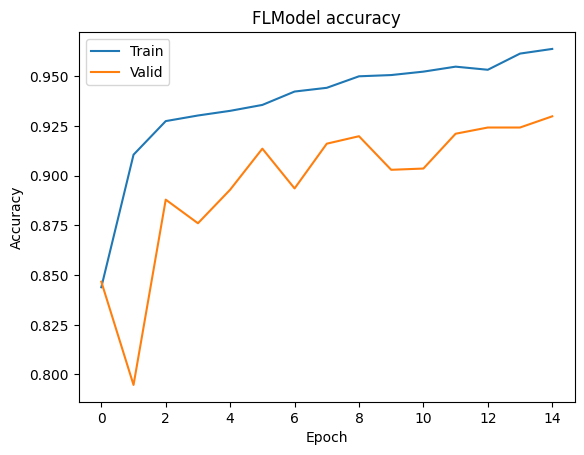

In [64]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history.global_history['multiclassaccuracy'])
plt.plot(history.global_history['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

### 小结
可以看到，将单机模式下的音频分类任务，迁移到隐语的联邦学习模式，不仅非常的容易，而且不需要开发者继续编写训练函数和测试函数，充分展现了隐语的易用性和好用性

# 总结

通过本教程，您将学习到：
- 如何基于 PyTorch 开展音频分类任务
- 如何编写少量代码即可将单机模式下的音频分类模型迁移到隐语的联邦学习框架之下 